# Demographics Data for Cohorts 1-3

Basic descriptive statistics and counts for each of the cohorts as well as the combined cohort

## Cohorts: 

- Cohort 1: MUSIC
- Cohort 2: GI-DAMPs
- Cohort 3: Online survey

In [4]:
import pandas as pd
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr, mannwhitneyu
import matplotlib.pyplot as plt

from src.data.loading import load_fatigue_dataset, load_online_survey_dataset
from src.visualization.plotting import plot_cucq_trajectory
from src.config.paths import DEMOGRAPHICS_DIR, ensure_output_dirs

## Load Datasets and Output Path Configuration

In [ ]:
ensure_output_dirs()
output_path = str(DEMOGRAPHICS_DIR)

In [3]:
# Cohort 1-2 Machine Learning Dataset
df_music_gidamps = load_fatigue_dataset()

# Cohort 3 Online Survey
df_online = load_online_survey_dataset()

# Cohorts 1-3 Combined
df_combined = pd.concat([df_online, df_music_gidamps], ignore_index=True)

# Cohort 1 MUSIC Demographics
df_music_demographics = pd.read_csv("data/music_demographics_111224.csv")

# Cohort 2 GI-DAMPs Demographics for ML Dataset
df_gidamps_demographics = pd.read_csv("data/gidamps_demographics_111224.csv")

## Cohort 3 Online Survey Demographics

In [4]:
print(f"Number of responses: {df_online.shape[0]}")

Number of responses: 1755


In [5]:
df_online["study_group"].value_counts()

study_group
cd        697
uc        571
hc        336
ibdu       90
unsure     27
Name: count, dtype: int64

In [6]:
print(
    "Number of IBD patients: "
    + str(
        df_online["study_group"].value_counts().cd
        + df_online["study_group"].value_counts().uc
        + df_online["study_group"].value_counts().ibdu
    )
)

Number of IBD patients: 1358


In [7]:
df_online["participant_location"].value_counts()

participant_location
England             841
Scotland            681
Outside UK          112
Wales                49
Northern Ireland     36
Name: count, dtype: int64

In [8]:
print(
    "Number of UK Participants: "
    + str(
        df_online["participant_location"].value_counts().England
        + df_online["participant_location"].value_counts().Scotland
        + df_online["participant_location"].value_counts().Wales
        + df_online["participant_location"].value_counts()["Northern Ireland"]
    )
)

Number of UK Participants: 1607


### Age Distribution

In [9]:
print(df_online.groupby("study_group")["age"].median())
# Calculate IQR by study group
iqr = df_online.groupby("study_group")["age"].quantile(0.75) - df_online.groupby(
    "study_group"
)["age"].quantile(0.25)
print("\nInterquartile Range (IQR) of Age by Study Group:")
print(iqr)

study_group
cd        42.0
hc        39.0
ibdu      40.0
uc        42.0
unsure    39.0
Name: age, dtype: float64

Interquartile Range (IQR) of Age by Study Group:
study_group
cd        19.00
hc        21.00
ibdu      18.00
uc        19.25
unsure    18.50
Name: age, dtype: float64


### Location Distribution

In [10]:
print(df_online.groupby("study_group")["participant_location"].value_counts())
print(
    df_online.groupby("study_group")["participant_location"].value_counts(
        normalize=True
    )
    * 100
)

study_group  participant_location
cd           England                 392
             Scotland                219
             Outside UK               48
             Wales                    22
             Northern Ireland         16
hc           Scotland                276
             England                  35
             Outside UK               20
             Wales                     2
             Northern Ireland          1
ibdu         England                  51
             Scotland                 33
             Outside UK                3
             Northern Ireland          2
             Wales                     1
uc           England                 359
             Scotland                135
             Outside UK               38
             Wales                    24
             Northern Ireland         15
unsure       Scotland                 18
             England                   4
             Outside UK                3
             Northern I

### Self-Reported Disease Activity

In [11]:
print(df_online.groupby("study_group")["self_reported_disease_activity"].value_counts())
print(
    df_online.groupby("study_group")["self_reported_disease_activity"].value_counts(
        normalize=True
    )
    * 100
)

study_group  self_reported_disease_activity
cd           remission                         312
             flaring                           252
             unsure                            132
             hc                                  1
hc           hc                                335
             unsure                              1
ibdu         remission                          35
             flaring                            29
             unsure                             26
uc           remission                         261
             flaring                           229
             unsure                             79
             hc                                  2
unsure       unsure                             13
             flaring                            10
             remission                           3
             hc                                  1
Name: count, dtype: int64
study_group  self_reported_disease_activity
cd           remiss

## Cohorts 1-2 Demographics (ML Cohort)

In [12]:
number_of_unique_participants = df_music_gidamps["study_id"].unique().shape[0]
print(f"Number of participants in music and gidamps: {number_of_unique_participants}")

Number of participants in music and gidamps: 535


In [13]:
print(
    f"Total Number of Unique Participants: {number_of_unique_participants + df_online.shape[0]}"
)

Total Number of Unique Participants: 2290


In [14]:
print(
    f"Total Number of CUCQ Responses: {df_online.shape[0] + df_music_gidamps.shape[0]}"
)

Total Number of CUCQ Responses: 2970


In [15]:
df_music_gidamps["aggregate_disease_activity"].value_counts()

aggregate_disease_activity
Active                   631
Biochemical remission    267
Remission                183
Name: count, dtype: int64

### Median CUCQ Scores in Cohort 1-2 Grouped by Disease Activity

In [16]:
# Get median CUCQ total by disease activity group
medians = df_music_gidamps.groupby("aggregate_disease_activity")["cucq_total"].median()
print("\nMedian CUCQ Total by Disease Activity:")
print(medians)

# Perform one-way ANOVA
# First remove any NaN values
df_clean = df_music_gidamps.dropna(subset=["aggregate_disease_activity", "cucq_total"])

# Get groups for ANOVA
groups = [
    group for _, group in df_clean.groupby("aggregate_disease_activity")["cucq_total"]
]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)

print("\nOne-way ANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")

# Perform post-hoc analysis with Bonferroni correction

# Create list of pairs for comparison
pairs = [
    ("Active", "Biochemical remission"),
    ("Active", "Remission"),
    ("Biochemical remission", "Remission"),
]

# Calculate Bonferroni corrected alpha
alpha = 0.05 / len(pairs)
print(f"\nBonferroni corrected alpha: {alpha:.4f}")

print("\nPost-hoc t-tests with Bonferroni correction:")
for group1, group2 in pairs:
    data1 = df_clean[df_clean["aggregate_disease_activity"] == group1]["cucq_total"]
    data2 = df_clean[df_clean["aggregate_disease_activity"] == group2]["cucq_total"]

    t_stat, p_val = ttest_ind(data1, data2)
    significant = "significant" if p_val < alpha else "not significant"

    print(f"\n{group1} vs {group2}:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_val:.4e}")
    print(f"Difference is {significant} at alpha = {alpha:.4f}")


Median CUCQ Total by Disease Activity:
aggregate_disease_activity
Active                   133.0
Biochemical remission     40.0
Remission                 39.0
Name: cucq_total, dtype: float64

One-way ANOVA Results:
F-statistic: 296.4611
p-value: 3.2904e-103

Bonferroni corrected alpha: 0.0167

Post-hoc t-tests with Bonferroni correction:

Active vs Biochemical remission:
t-statistic: 19.2891
p-value: 1.4596e-69
Difference is significant at alpha = 0.0167

Active vs Remission:
t-statistic: 17.1058
p-value: 3.2972e-56
Difference is significant at alpha = 0.0167

Biochemical remission vs Remission:
t-statistic: 0.6472
p-value: 5.1783e-01
Difference is not significant at alpha = 0.0167


## Combined Cohorts 1-3

### Median CUCQ Scores Across IBD and non-IBD Groups in Cohorts 1-3

In [17]:
medians = df_online.groupby("self_reported_disease_activity")["cucq_total"].median()
print("\nMedian CUCQ Total by Disease Activity:")
print(medians)


Median CUCQ Total by Disease Activity:
self_reported_disease_activity
flaring      151.5
hc            27.0
remission     70.0
unsure        94.0
Name: cucq_total, dtype: float64


In [18]:
df_combined["study_group"].value_counts()

study_group
cd        697
uc        571
hc        336
ibdu       90
unsure     27
Name: count, dtype: int64

In [19]:
# Create combined disease activity column by coalescing self_reported_disease_activity and aggregate_disease_activity
df_combined["combined_disease_activity"] = df_combined[
    "self_reported_disease_activity"
].fillna(df_combined["aggregate_disease_activity"])

In [20]:
df_combined["combined_disease_activity"].value_counts()

combined_disease_activity
Active                   631
remission                611
flaring                  520
hc                       339
Biochemical remission    267
unsure                   251
Remission                183
Name: count, dtype: int64

In [21]:
combined_disease_activity_map = {
    "Active": "active",
    "remission": "remission",
    "flaring": "active",
    "Biochemical remission": "remission",
    "Remission": "remission",
    "hc": "hc",
    "unsure": "unsure",
}

df_combined["combined_disease_activity"] = df_combined["combined_disease_activity"].map(
    combined_disease_activity_map
)
df_combined["combined_disease_activity"].value_counts()


combined_disease_activity
active       1151
remission    1061
hc            339
unsure        251
Name: count, dtype: int64

In [22]:
print(
    "Number of IBD participants in cohorts 1-3: "
    + str(
        df_combined["study_group"].value_counts().cd
        + df_combined["study_group"].value_counts().uc
        + df_combined["study_group"].value_counts().ibdu
    )
)

Number of IBD participants in cohorts 1-3: 1358


### Fatigue days in Cohorts 1-3

#### Number of Fatigue High Patients despite Remission

In [23]:
fatigue_despite_remission_df = df_combined[
    df_combined["combined_disease_activity"].isin(["remission"])
]

In [24]:
fatigue_despite_remission_df["cucq_5_greater_than_10"] = (
    fatigue_despite_remission_df["cucq_5"] >= 10
)
print(fatigue_despite_remission_df["cucq_5_greater_than_10"].value_counts())
print(
    fatigue_despite_remission_df["cucq_5_greater_than_10"].value_counts(normalize=True)
    * 100
)

cucq_5_greater_than_10
False    598
True     463
Name: count, dtype: int64
cucq_5_greater_than_10
False    56.361923
True     43.638077
Name: proportion, dtype: float64


/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/2808869279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fatigue_despite_remission_df["cucq_5_greater_than_10"] = (


#### Active IBD vs Remission IBD

In [25]:
combined_fatigued_df = df_combined[
    df_combined["combined_disease_activity"].isin(["active", "remission"])
]
print(combined_fatigued_df.groupby("combined_disease_activity")["cucq_5"].median())
print(combined_fatigued_df["combined_disease_activity"].value_counts())

# Perform chi-square test
chi_square_table = pd.crosstab(
    combined_fatigued_df["combined_disease_activity"], combined_fatigued_df["cucq_5"]
)
chi2, p_value = chi2_contingency(chi_square_table)[:2]

print("\nChi-square test for CUCQ Q5 (Fatigue) scores:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")

combined_disease_activity
active       14.0
remission     7.0
Name: cucq_5, dtype: float64
combined_disease_activity
active       1151
remission    1061
Name: count, dtype: int64

Chi-square test for CUCQ Q5 (Fatigue) scores:
Chi-square statistic: 267.6149
p-value: 0.000000


#### Remission IBD vs Non-IBD healthy controls

In [26]:
combined_fatigued_df = df_combined[
    df_combined["combined_disease_activity"].isin(["remission", "hc"])
]
print(combined_fatigued_df.groupby("combined_disease_activity")["cucq_5"].median())
print(combined_fatigued_df["combined_disease_activity"].value_counts())

# Perform chi-square test
chi_square_table = pd.crosstab(
    combined_fatigued_df["combined_disease_activity"], combined_fatigued_df["cucq_5"]
)
chi2, p_value = chi2_contingency(chi_square_table)[:2]

print("\nChi-square test for CUCQ Q5 (Fatigue) scores:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")

combined_disease_activity
hc           4.0
remission    7.0
Name: cucq_5, dtype: float64
combined_disease_activity
remission    1061
hc            339
Name: count, dtype: int64

Chi-square test for CUCQ Q5 (Fatigue) scores:
Chi-square statistic: 129.4734
p-value: 0.000000


### Defining clinical threshold for fatigue

Using 10 out of 14 days as the threshold for fatigue into fatigue-high and fatigue-low

In [27]:
df_combined["cucq_5_greater_than_threshold"] = df_combined["cucq_5"] >= 10

In [28]:
# subsetting by combined disease activity

# Remove unsure responses
subset_df = df_combined[
    df_combined["combined_disease_activity"].isin(["active", "remission", "hc"])
]

print(subset_df["combined_disease_activity"].value_counts())
print(
    subset_df.groupby("combined_disease_activity")[
        "cucq_5_greater_than_threshold"
    ].value_counts()
)
print(
    subset_df.groupby("combined_disease_activity")[
        "cucq_5_greater_than_threshold"
    ].value_counts(normalize=True)
    * 100
)

combined_disease_activity
active       1151
remission    1061
hc            339
Name: count, dtype: int64
combined_disease_activity  cucq_5_greater_than_threshold
active                     True                             866
                           False                            285
hc                         False                            291
                           True                              48
remission                  False                            598
                           True                             463
Name: count, dtype: int64
combined_disease_activity  cucq_5_greater_than_threshold
active                     True                             75.238923
                           False                            24.761077
hc                         False                            85.840708
                           True                             14.159292
remission                  False                            56.361923
                    

In [29]:
print(
    subset_df.groupby("cucq_5_greater_than_threshold")[
        "cucq_5_greater_than_threshold"
    ].value_counts()
)
print(df_combined.groupby("cucq_5_greater_than_threshold")["cucq_total"].median())

# Create contingency table for chi-square test
contingency_table = pd.crosstab(
    subset_df["combined_disease_activity"], subset_df["cucq_5_greater_than_threshold"]
)

# Perform chi-square test
chi2, p_value = chi2_contingency(contingency_table)[:2]

print("\nChi-square test for fatigue threshold by disease activity:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")


cucq_5_greater_than_threshold
False    1174
True     1377
Name: count, dtype: int64
cucq_5_greater_than_threshold
False     38.0
True     130.0
Name: cucq_total, dtype: float64

Chi-square test for fatigue threshold by disease activity:
Chi-square statistic: 471.4708
p-value: 0.000000


In [30]:
print(len(df_combined["cucq_5_greater_than_threshold"]))
print(df_combined["cucq_5_greater_than_threshold"].value_counts())
print(df_combined["cucq_5_greater_than_threshold"].value_counts(normalize=True) * 100)

# Calculate percentage of patients with fatigue score >= 10 by disease activity group
fatigue_by_activity = (
    df_combined.groupby("combined_disease_activity")[
        "cucq_5_greater_than_threshold"
    ].value_counts(normalize=True)
    * 100
)
print("\nPercentage of patients with fatigue score >= 10 by disease activity:")
print(fatigue_by_activity)

# Chi-square test between disease activity groups
chi_square_table = pd.crosstab(
    df_combined["combined_disease_activity"],
    df_combined["cucq_5_greater_than_threshold"],
)
chi2, p_value = chi2_contingency(chi_square_table)[:2]

print("\nChi-square test results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")

2970
cucq_5_greater_than_threshold
True     1602
False    1368
Name: count, dtype: int64
cucq_5_greater_than_threshold
True     53.939394
False    46.060606
Name: proportion, dtype: float64

Percentage of patients with fatigue score >= 10 by disease activity:
combined_disease_activity  cucq_5_greater_than_threshold
active                     True                             75.238923
                           False                            24.761077
hc                         False                            85.840708
                           True                             14.159292
remission                  False                            56.361923
                           True                             43.638077
unsure                     True                             65.737052
                           False                            34.262948
Name: proportion, dtype: float64

Chi-square test results:
Chi-square statistic: 486.0458
p-value: 0.000000


#### Correlation between cucq_5 and cucq_total

2902
Correlation coefficient between CUCQ Q5 and total CUCQ: 0.729
P-value: 0.00000


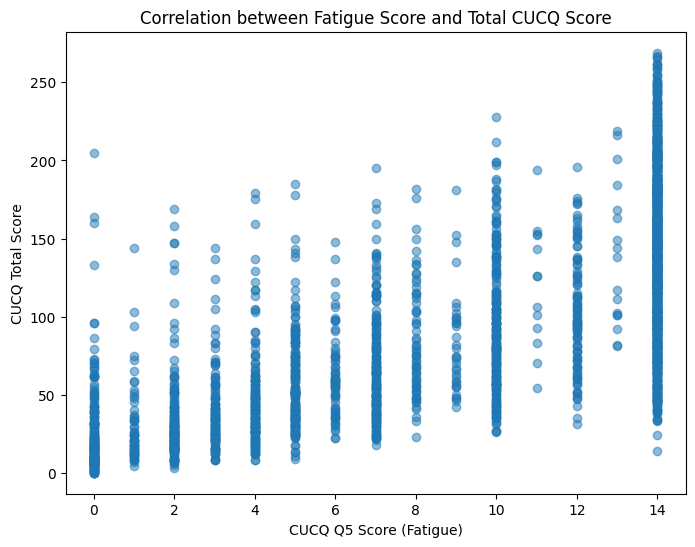

In [31]:
# Calculate correlation between CUCQ Q5 (fatigue) and total CUCQ score
df_combined = df_combined.dropna(subset=["cucq_5", "cucq_total"])
correlation, p_value = pearsonr(df_combined["cucq_5"], df_combined["cucq_total"])

print(len(df_combined["cucq_5"]))
print(f"Correlation coefficient between CUCQ Q5 and total CUCQ: {correlation:.3f}")
print(f"P-value: {p_value:.5f}")

# Create scatter plot to visualize relationship
plt.figure(figsize=(8, 6))
plt.scatter(df_combined["cucq_5"], df_combined["cucq_total"], alpha=0.5)
plt.xlabel("CUCQ Q5 Score (Fatigue)")
plt.ylabel("CUCQ Total Score")
plt.title("Correlation between Fatigue Score and Total CUCQ Score")
plt.show()

### Coefficient of Variation for CUCQ Scores

In [32]:
# Calculate CV for cucq_total
mean_cucq = df_combined["cucq_total"].mean()
std_cucq = df_combined["cucq_total"].std()
cv_cucq = (std_cucq / mean_cucq) * 100

print(f"Coefficient of Variation for CUCQ Total: {cv_cucq:.2f}%")


Coefficient of Variation for CUCQ Total: 66.21%


In [33]:
# Group by combined_disease_activity and calculate mean, std, and CV
grouped_stats = df_combined.groupby("combined_disease_activity")["cucq_total"].agg(
    ["mean", "std"]
)
grouped_stats["cv"] = (grouped_stats["std"] / grouped_stats["mean"]) * 100

# Round the results to 2 decimal places
grouped_stats = grouped_stats.round(2)

print("Coefficient of Variation by Disease Activity Group:")
print("\nMean, Standard Deviation, and CV (%):")
print(grouped_stats)

Coefficient of Variation by Disease Activity Group:

Mean, Standard Deviation, and CV (%):
                             mean    std     cv
combined_disease_activity                      
active                     139.08  57.27  41.18
hc                          30.88  20.60  66.72
remission                   63.82  40.86  64.02
unsure                      99.78  45.76  45.87


In [34]:
medians = df_combined.groupby("combined_disease_activity")["cucq_total"].median()
print("\nMedian CUCQ Total by Disease Activity:")
print(medians)


Median CUCQ Total by Disease Activity:
combined_disease_activity
active       143.0
hc            27.0
remission     56.0
unsure        94.0
Name: cucq_total, dtype: float64


In [35]:
# Perform one-way ANOVA on CUCQ total by combined disease activity
# First remove any NaN values
df_clean = df_combined.dropna(subset=["combined_disease_activity", "cucq_total"])

# Get groups for ANOVA
groups = [
    group for _, group in df_clean.groupby("combined_disease_activity")["cucq_total"]
]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)

print("\nOne-way ANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")

# Post-hoc analysis with Bonferroni correction if ANOVA is significant

# Create list of pairs for comparison
groups = sorted(df_clean["combined_disease_activity"].unique())
pairs = [(a, b) for i, a in enumerate(groups) for b in groups[i + 1 :]]

# Calculate Bonferroni corrected alpha
alpha = 0.05 / len(pairs)
print(f"\nBonferroni corrected alpha: {alpha:.4f}")

print("\nPost-hoc t-tests with Bonferroni correction:")
for group1, group2 in pairs:
    data1 = df_clean[df_clean["combined_disease_activity"] == group1]["cucq_total"]
    data2 = df_clean[df_clean["combined_disease_activity"] == group2]["cucq_total"]

    t_stat, p_val = ttest_ind(data1, data2)
    significant = "significant" if p_val < alpha else "not significant"

    print(f"\n{group1} vs {group2}:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_val:.4e}")
    print(f"Difference is {significant} at alpha = {alpha:.4f}")



One-way ANOVA Results:
F-statistic: 698.9966
p-value: 0.0000e+00

Bonferroni corrected alpha: 0.0083

Post-hoc t-tests with Bonferroni correction:

active vs hc:
t-statistic: 34.1326
p-value: 5.4563e-189
Difference is significant at alpha = 0.0083

active vs remission:
t-statistic: 35.2327
p-value: 4.9749e-216
Difference is significant at alpha = 0.0083

active vs unsure:
t-statistic: 10.1848
p-value: 1.5051e-23
Difference is significant at alpha = 0.0083

hc vs remission:
t-statistic: -14.2701
p-value: 3.2071e-43
Difference is significant at alpha = 0.0083

hc vs unsure:
t-statistic: -24.5636
p-value: 3.1877e-92
Difference is significant at alpha = 0.0083

remission vs unsure:
t-statistic: -12.2359
p-value: 1.1452e-32
Difference is significant at alpha = 0.0083


## Cohort 1 MUSIC Demographics

### Age

In [36]:
# Age

print(df_music_demographics.groupby("study_group")["age"].median())
iqr = df_music_demographics.groupby("study_group")["age"].quantile(
    0.75
) - df_music_demographics.groupby("study_group")["age"].quantile(0.25)
print("\nInterquartile Range (IQR) of Age by Study Group:")
print(iqr)
# Perform Mann-Whitney U test
group_cd = df_music_demographics[df_music_demographics["study_group"] == "cd"]["age"]
group_uc = df_music_demographics[df_music_demographics["study_group"] == "uc"]["age"]

u_stat, p_val = mannwhitneyu(group_cd, group_uc)

print("\nMann-Whitney U Test Results:")
print(f"U-statistic: {u_stat:.4f}")
print(f"p-value: {p_val:.4f}")

study_group
cd    32.5
uc    39.0
Name: age, dtype: float64

Interquartile Range (IQR) of Age by Study Group:
study_group
cd    25.75
uc    25.25
Name: age, dtype: float64

Mann-Whitney U Test Results:
U-statistic: 4254.5000
p-value: 0.0597


### Sex

In [37]:
# Sex

print(df_music_demographics.groupby("study_group")["sex"].value_counts())

# Perform chi-square test on sex by study group
chi_square_table = pd.crosstab(
    df_music_demographics["study_group"], df_music_demographics["sex"]
)
chi2, p_value = chi2_contingency(chi_square_table)[:2]

print("\nChi-square test for sex by study group:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")

study_group  sex   
cd           male      73
             female    53
uc           male      47
             female    33
Name: count, dtype: int64

Chi-square test for sex by study group:
Chi-square statistic: 0.0000
p-value: 1.0000


### Montreal Classification

In [38]:
# Montreal Classification
columns = [
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_perianal",
    "montreal_upper_gi",
    "montreal_uc_extent",
    "montreal_uc_severity",
]

for column in columns:
    cd_count = df_music_demographics[df_music_demographics["study_group"] == "cd"][
        column
    ].value_counts()
    cd_percentage = (
        df_music_demographics[df_music_demographics["study_group"] == "cd"][
            column
        ].value_counts(normalize=True)
        * 100
    )
    uc_count = df_music_demographics[df_music_demographics["study_group"] == "uc"][
        column
    ].value_counts()
    uc_percentage = (
        df_music_demographics[df_music_demographics["study_group"] == "uc"][
            column
        ].value_counts(normalize=True)
        * 100
    )

    print(cd_count)
    print(cd_percentage)
    print(uc_count)
    print(uc_percentage)

montreal_cd_location
L2    57
L3    50
L1    16
Name: count, dtype: int64
montreal_cd_location
L2    46.341463
L3    40.650407
L1    13.008130
Name: proportion, dtype: float64
Series([], Name: count, dtype: int64)
Series([], Name: proportion, dtype: float64)
montreal_cd_behaviour
B1    80
B2    24
B3    16
Name: count, dtype: int64
montreal_cd_behaviour
B1    66.666667
B2    20.000000
B3    13.333333
Name: proportion, dtype: float64
Series([], Name: count, dtype: int64)
Series([], Name: proportion, dtype: float64)
montreal_perianal
1.0    17
Name: count, dtype: int64
montreal_perianal
1.0    100.0
Name: proportion, dtype: float64
Series([], Name: count, dtype: int64)
Series([], Name: proportion, dtype: float64)
montreal_upper_gi
1.0    5
Name: count, dtype: int64
montreal_upper_gi
1.0    100.0
Name: proportion, dtype: float64
Series([], Name: count, dtype: int64)
Series([], Name: proportion, dtype: float64)
Series([], Name: count, dtype: int64)
Series([], Name: proportion, dtype: float

### Physician Global Assessment

In [39]:
# Physician Global Assessment

print(
    df_music_demographics.groupby("study_group")[
        "physician_global_assessment"
    ].value_counts()
)
print(
    df_music_demographics.groupby("study_group")[
        "physician_global_assessment"
    ].value_counts(normalize=True)
    * 100
)

study_group  physician_global_assessment
cd           moderate                       62
             mild                           46
             severe                         16
             remission                       2
uc           moderate                       38
             severe                         20
             mild                           19
             remission                       3
Name: count, dtype: int64
study_group  physician_global_assessment
cd           moderate                       49.206349
             mild                           36.507937
             severe                         12.698413
             remission                       1.587302
uc           moderate                       47.500000
             severe                         25.000000
             mild                           23.750000
             remission                       3.750000
Name: proportion, dtype: float64


### Clinical Measurements

In [40]:
# Remove < and > symbols as well as text from calprotectin column
df_music_demographics["calprotectin"] = (
    df_music_demographics["calprotectin"].astype(str).str.replace(r"\D", "", regex=True)
)
df_music_demographics["calprotectin"] = pd.to_numeric(
    df_music_demographics["calprotectin"], errors="coerce"
)

columns = [
    "weight",
    "haemoglobin",
    "white_cell_count",
    "platelets",
    "albumin",
    "crp",
    "calprotectin",
]

for column in columns:
    print(column)
    print(df_music_demographics.groupby("study_group")[column].describe())
    group_cd = df_music_demographics[df_music_demographics["study_group"] == "cd"][
        column
    ].dropna()
    group_uc = df_music_demographics[df_music_demographics["study_group"] == "uc"][
        column
    ].dropna()

    t_stat, p_val = ttest_ind(group_cd, group_uc, equal_var=False)

    print(f"T-test results for {column}:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_val:.4f}")
    print("\n")

weight
             count      mean        std   min    25%    50%    75%    max
study_group                                                              
cd           125.0  78.39032  19.798005  41.0  66.50  75.00  87.10  145.0
uc            80.0  77.89875  19.913303  52.5  64.95  73.85  85.25  166.1
T-test results for weight:
t-statistic: 0.1728
p-value: 0.8630


haemoglobin
             count        mean        std   min    25%    50%     75%    max
study_group                                                                 
cd           123.0  133.715447  16.334877  87.0  122.5  135.0  144.00  166.0
uc            80.0  129.800000  15.416907  84.0  121.0  131.0  139.25  159.0
T-test results for haemoglobin:
t-statistic: 1.7270
p-value: 0.0859


white_cell_count
             count      mean       std  min   25%  50%   75%   max
study_group                                                       
cd           123.0  9.036585  4.471408  3.4  6.30  8.3  10.2  40.6
uc            80.0  9.97

### Study Centre

In [41]:
print(df_music_demographics.groupby("study_group")["study_center"].value_counts())
print(
    df_music_demographics.groupby("study_group")["study_center"].value_counts(
        normalize=True
    )
    * 100
)

study_group  study_center
cd           edinburgh       73
             glasgow         45
             dundee           8
uc           edinburgh       52
             dundee          21
             glasgow          7
Name: count, dtype: int64
study_group  study_center
cd           edinburgh       57.936508
             glasgow         35.714286
             dundee           6.349206
uc           edinburgh       65.000000
             dundee          26.250000
             glasgow          8.750000
Name: proportion, dtype: float64


### Disease Activity

In [42]:
df_timepoint_1 = df_music_gidamps[
    df_music_gidamps["redcap_event_name"] == "timepoint_1"
][["study_id", "aggregate_disease_activity"]]

df_music_demographics = df_music_demographics.merge(
    df_timepoint_1, on="study_id", how="left"
)

In [43]:
print(
    df_music_demographics.groupby("study_group")[
        "aggregate_disease_activity"
    ].value_counts()
)
print(
    df_music_demographics.groupby("study_group")[
        "aggregate_disease_activity"
    ].value_counts(normalize=True)
    * 100
)

# Perform chi-square test on aggregate disease activity by study group
chi_square_table = pd.crosstab(
    df_music_demographics["study_group"],
    df_music_demographics["aggregate_disease_activity"],
)
chi2, p_value = chi2_contingency(chi_square_table)[:2]

print("\nChi-square test for aggregate disease activity by study group:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")

study_group  aggregate_disease_activity
cd           Active                        88
             Biochemical remission         10
             Remission                      7
uc           Active                        61
             Biochemical remission          5
             Remission                      2
Name: count, dtype: int64
study_group  aggregate_disease_activity
cd           Active                        83.809524
             Biochemical remission          9.523810
             Remission                      6.666667
uc           Active                        89.705882
             Biochemical remission          7.352941
             Remission                      2.941176
Name: proportion, dtype: float64

Chi-square test for aggregate disease activity by study group:
Chi-square statistic: 1.4920
p-value: 0.4743


### Baseline Endoscopic Scores

In [44]:
columns_to_select = [
    "study_id",
    "study_group",
    "sescd_calc",
    "sescd_noncalc",
    "uceis_calc",
    "uceis_noncalc",
    "mayo_endoscopic_findings",
]

df_music_endo = df_music_demographics[columns_to_select]

In [45]:
# sescd

df_music_endo["sescd_noncalc"] = df_music_endo["sescd_noncalc"].str.replace(
    r"/56", "", regex=True
)
df_music_endo["sescd_noncalc"] = df_music_endo["sescd_noncalc"].str.replace(
    "UCEIS = 7", "", regex=False
)

df_music_endo["sescd_noncalc"] = pd.to_numeric(
    df_music_endo["sescd_noncalc"], errors="coerce"
)
df_music_endo["sescd_calc"].fillna(df_music_endo["sescd_noncalc"], inplace=True)

/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/2114460288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_endo["sescd_noncalc"] = df_music_endo["sescd_noncalc"].str.replace(
/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/2114460288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_endo["sescd_noncalc"] = df_music_endo["sescd_noncalc"].str.replace(
/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/2114460288.py:10: SettingWithCopyWarn

In [46]:
df_music_endo["uceis_calc"].fillna(df_music_endo["uceis_noncalc"], inplace=True)

/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/4165713995.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_music_endo["uceis_calc"].fillna(df_music_endo["uceis_noncalc"], inplace=True)
/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/4165713995.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan '6' nan '1' nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan na

In [47]:
print(df_music_endo.groupby("study_group")["sescd_calc"].median())
iqr = df_music_endo.groupby("study_group")["sescd_calc"].quantile(
    0.75
) - df_music_endo.groupby("study_group")["sescd_calc"].quantile(0.25)
print("\nInterquartile Range (IQR) of SES-CD by Study Group:")
print(iqr)

study_group
cd    10.0
uc     NaN
Name: sescd_calc, dtype: float64

Interquartile Range (IQR) of SES-CD by Study Group:
study_group
cd    8.0
uc    NaN
Name: sescd_calc, dtype: float64


In [48]:
df_music_endo["uceis_calc"] = pd.to_numeric(
    df_music_endo["uceis_calc"], errors="coerce"
)

print(df_music_endo.groupby("study_group")["uceis_calc"].median())

iqr = df_music_endo.groupby("study_group")["uceis_calc"].quantile(
    0.75
) - df_music_endo.groupby("study_group")["uceis_calc"].quantile(0.25)
print("\nInterquartile Range (IQR) of UCEIS by Study Group:")
print(iqr)

study_group
cd    NaN
uc    4.0
Name: uceis_calc, dtype: float64

Interquartile Range (IQR) of UCEIS by Study Group:
study_group
cd    NaN
uc    3.0
Name: uceis_calc, dtype: float64


/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/3901354363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_endo["uceis_calc"] = pd.to_numeric(


In [49]:
print(df_music_endo.groupby("study_group")["mayo_endoscopic_findings"].value_counts())
print(
    df_music_endo.groupby("study_group")["mayo_endoscopic_findings"].value_counts(
        normalize=True
    )
    * 100
)

study_group  mayo_endoscopic_findings
uc           2.0                         46
             3.0                         15
             1.0                          9
Name: count, dtype: int64
study_group  mayo_endoscopic_findings
uc           2.0                         65.714286
             3.0                         21.428571
             1.0                         12.857143
Name: proportion, dtype: float64


### Baseline Treatment Exposure

In [50]:
# Create any_thiopurine column
df_music_demographics["any_thiopurine"] = (
    (df_music_demographics["baseline_aza"] == 1)
    | (df_music_demographics["baseline_mp"] == 1)
).astype(int)
df_music_demographics["any_biologic"] = (
    (df_music_demographics["baseline_ifx"] == 1)
    | (df_music_demographics["baseline_ada"] == 1)
    | (df_music_demographics["baseline_vedo"] == 1)
    | (df_music_demographics["baseline_uste"] == 1)
    | (df_music_demographics["baseline_risa"] == 1)
).astype(int)
df_music_demographics["any_jaki"] = (
    (df_music_demographics["baseline_tofa"] == 1)
    | (df_music_demographics["baseline_filgo"] == 1)
).astype(int)

In [51]:
columns = [
    "any_thiopurine",
    "any_biologic",
    "any_jaki",
    "baseline_mp",
    "baseline_aza",
    "baseline_mtx",
    "baseline_ifx",
    "baseline_ada",
    "baseline_vedo",
    "baseline_uste",
    "baseline_goli",
    "baseline_risa",
    "baseline_tofa",
    "baseline_filgo",
]

meds_dict = []

for column in columns:
    drug = column
    try:
        cd_count = (
            df_music_demographics.groupby("study_group")[column]
            .value_counts()
            .loc["cd", 1]
        )
        cd_percentage = (
            df_music_demographics.groupby("study_group")[column]
            .value_counts(normalize=True)
            .loc["cd", 1]
            * 100
        )
    except KeyError:
        cd_percentage = 0
        cd_count = 0
    try:
        uc_count = (
            df_music_demographics.groupby("study_group")[column]
            .value_counts()
            .loc["uc", 1]
        )

        uc_percentage = (
            df_music_demographics.groupby("study_group")[column]
            .value_counts(normalize=True)
            .loc["uc", 1]
            * 100
        )
    except KeyError:
        uc_percentage = 0
        uc_count = 0

    # CHI Square Testing
    chi_square_table = pd.crosstab(
        df_music_demographics["study_group"], df_music_demographics[column]
    )
    chi2, p_value = chi2_contingency(chi_square_table)[:2]
    p_value = round(p_value, 5)

    meds_dict.append(
        {
            "drug": drug,
            "cd_count": cd_count,
            "cd_percentage": cd_percentage,
            "uc_count": uc_count,
            "uc_percentage": uc_percentage,
            "p_value": p_value,
            # "chi2": chi2, # uncomment if you wish to see the chi square test statistic
        },
    )

print(pd.DataFrame(meds_dict))

              drug  cd_count  cd_percentage  uc_count  uc_percentage  p_value
0   any_thiopurine        41      32.539683        21          26.25  0.42176
1     any_biologic        39      30.952381        18          22.50  0.24529
2         any_jaki         1       0.793651         5           6.25  0.06508
3      baseline_mp         8       6.349206         4           5.00  0.92211
4     baseline_aza        39      30.952381        21          26.25  0.57094
5     baseline_mtx         3       2.380952         0           0.00  0.42741
6     baseline_ifx        18      14.285714         9          11.25  0.67636
7     baseline_ada        28      22.222222         7           8.75  0.02039
8    baseline_vedo         9       7.142857         9          11.25  0.44470
9    baseline_uste         4       3.174603         3           3.75  1.00000
10   baseline_goli         0       0.000000         0           0.00  1.00000
11   baseline_risa         1       0.793651         0           

## Cohort 1 MUSIC Longitudinal Completion Data

In [52]:
df_music = df_music_gidamps[df_music_gidamps["study"] == "MUSIC"]
df_music = df_music[
    [
        "study_id",
        "redcap_event_name",
        "cucq_total",
        "cmh",
        "aggregate_disease_activity",
        "cucq_5",
    ]
]


In [53]:
timepoint_5_participants_count = len(
    df_music[df_music["redcap_event_name"] == "timepoint_5"]["study_id"].unique()
)

print(
    f"Number of participants who completed timepoint 5: {timepoint_5_participants_count}"
)

Number of participants who completed timepoint 5: 147


In [54]:
timepoint_5_participants = df_music[df_music["redcap_event_name"] == "timepoint_5"][
    "study_id"
].unique()
df_music_completed = df_music[df_music["study_id"].isin(timepoint_5_participants)]
print(f"Number of rows in filtered dataset: {len(df_music_completed)}")


Number of rows in filtered dataset: 734


In [55]:
df_music_completed[df_music_completed["redcap_event_name"] == "timepoint_5"][
    "aggregate_disease_activity"
].value_counts()

aggregate_disease_activity
Biochemical remission    55
Active                   43
Remission                22
Name: count, dtype: int64

### CUCQ Trajectories Based on Disease Activity at 12 Months

In [56]:
# Create a dictionary of study_id to disease activity at timepoint 5
timepoint_5_activities = df_music_completed[df_music_completed['redcap_event_name'] == 'timepoint_5'][['study_id', 'aggregate_disease_activity']]
activity_dict = timepoint_5_activities.set_index('study_id')['aggregate_disease_activity'].to_dict()

# Create new column and map the activities
df_music_completed['timepoint_5_activity'] = df_music_completed['study_id'].map(activity_dict)

/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/1411273813.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_completed['timepoint_5_activity'] = df_music_completed['study_id'].map(activity_dict)


In [58]:
# To simplify the visualization we will collapse Biocehmical remission and Remission into a single category

mapping_dictionary = {
    "Active": "Active",
    "Biochemical remission": "Remission",
    "Remission": "Remission",
}

df_music_completed["timepoint_5_activity_collapsed"] = df_music_completed[
    "timepoint_5_activity"
].map(mapping_dictionary)

/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_18256/3375992657.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_completed["timepoint_5_activity_collapsed"] = df_music_completed[


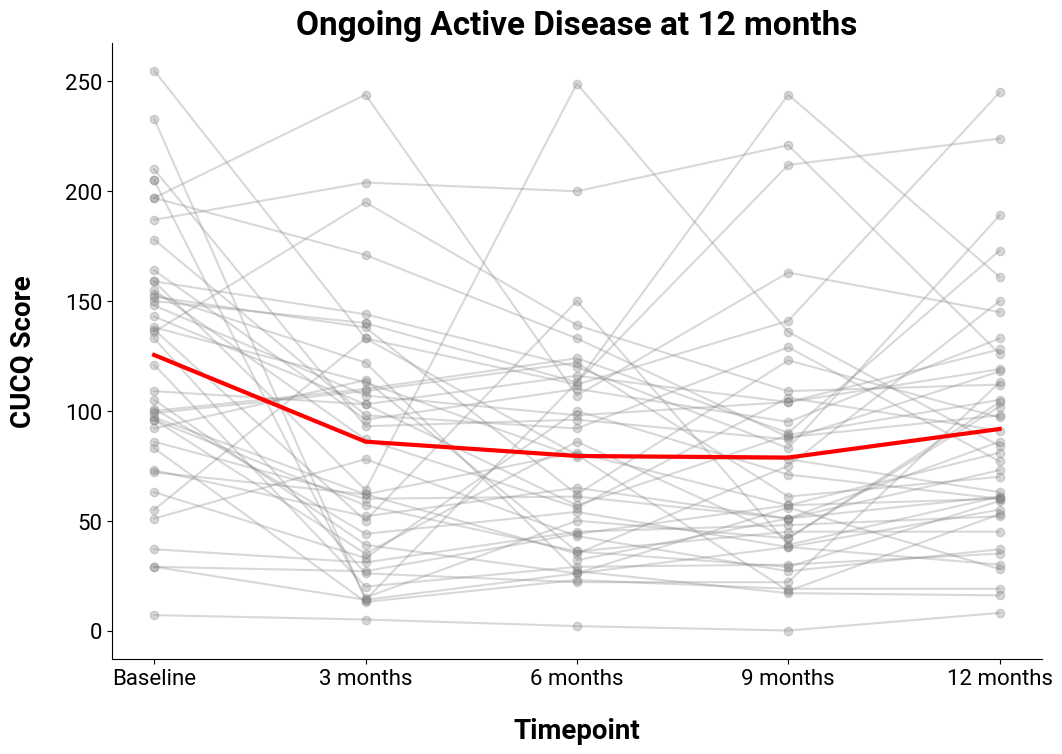

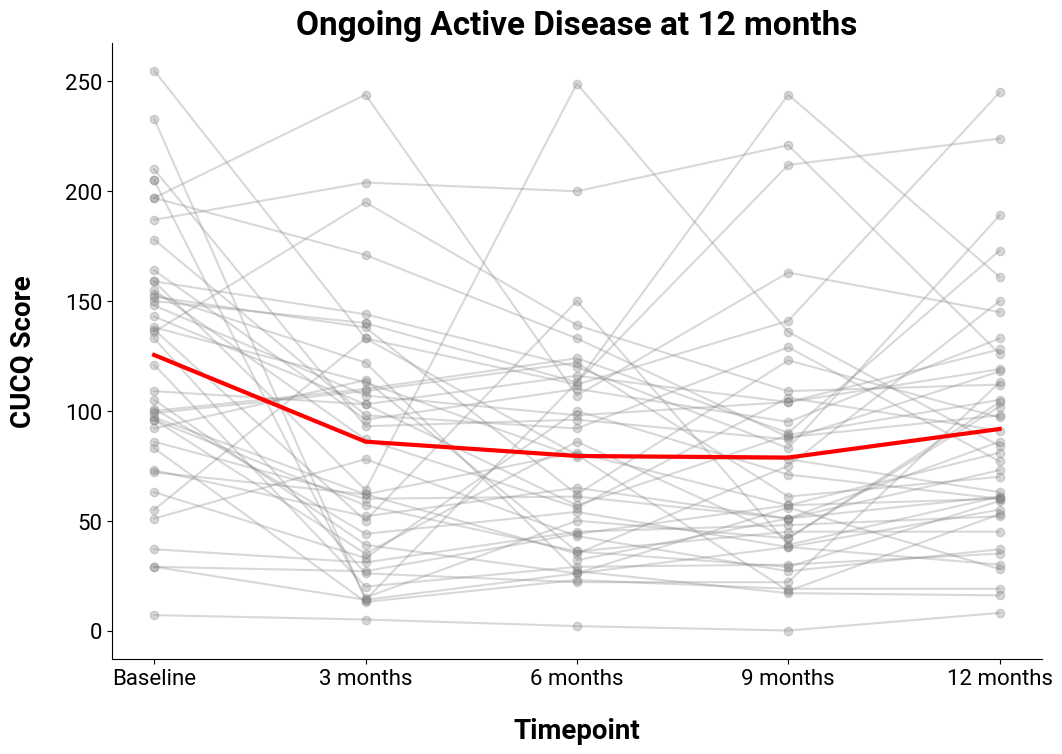

In [ ]:
filename = output_path + "music_cucq_active_at_12_months.png"

plot_cucq_trajectory(
    df_music_completed[
        df_music_completed["timepoint_5_activity_collapsed"] == "Active"
    ],
    title="Ongoing Active Disease at 12 months",
    output_path=filename,
)

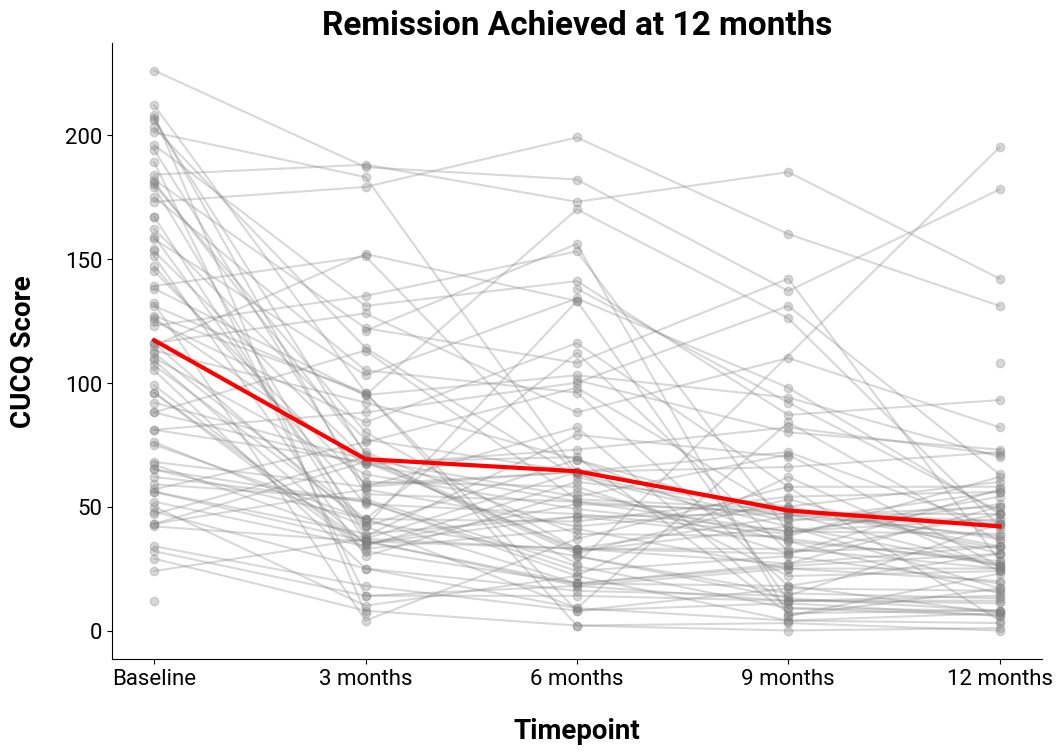

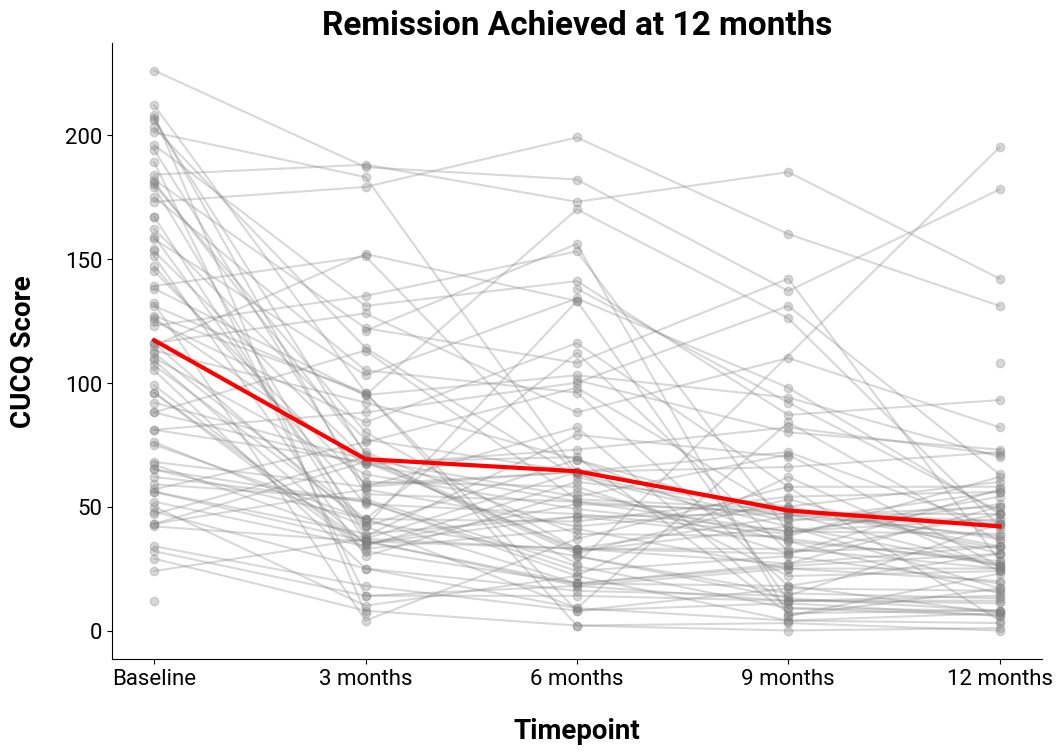

In [61]:
filename = output_path + "music_cucq_remission_at_12_months.png"

plot_cucq_trajectory(
    df_music_completed[
        df_music_completed["timepoint_5_activity_collapsed"] == "Remission"
    ],
    title="Remission Achieved at 12 months",
    output_path=filename,
)

In [ ]:
# Complete mucosal healing ie. follow up scope at 3-6 months is recorded on timepoint 2
# We use timepoint 2 CMH to work out which participants achieve CMH
# We will therefore obtain this value and fill it in all the other timepoints for analysis

timepoint_2_cmh = df_music_completed[
    df_music_completed["redcap_event_name"] == "timepoint_2"
][["study_id", "cmh"]]
timepoint_2_cmh_dict = timepoint_2_cmh.set_index("study_id")["cmh"].to_dict()
df_music_completed["cmh"] = df_music_completed["study_id"].map(timepoint_2_cmh_dict)

## Cohort 1 MUSIC - CUCQ scores and mucosal healing outcome

In [ ]:
print(
    df_music_completed[df_music_completed["redcap_event_name"] == "timepoint_5"]
    .groupby("cmh")["cmh"]
    .value_counts()
)

medians = df_music_completed.groupby("cmh")["cucq_total"].median()
print("\nMedian CUCQ Total by Complete Mucosal Healing Status:")
print(medians)

# Perform one-way ANOVA on CUCQ total by CMH status
# First remove any NaN values
df_clean = df_music_completed.dropna(subset=["cmh", "cucq_total"])

# Get groups for ANOVA
groups = [group for _, group in df_clean.groupby("cmh")["cucq_total"]]

# Perform ANOVA
f_stat, p_val = f_oneway(*groups)

print("\nOne-way ANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.2f}")

# Post-hoc analysis with Bonferroni correction
# Create list of pairs for comparison
groups = sorted(df_clean["cmh"].unique())
pairs = [(a, b) for i, a in enumerate(groups) for b in groups[i + 1 :]]

# Calculate Bonferroni corrected alpha
alpha = 0.05 / len(pairs)
print(f"\nBonferroni corrected alpha: {alpha:.4f}")

print("Post-hoc t-tests with Bonferroni correction:")
for group1, group2 in pairs:
    data1 = df_clean[df_clean["cmh"] == group1]["cucq_total"]
    data2 = df_clean[df_clean["cmh"] == group2]["cucq_total"]

    t_stat, p_val = ttest_ind(data1, data2)
    significant = "significant" if p_val < alpha else "not significant"

    print(f"\n{group1} vs {group2}:")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_val:.4e}")
    print(f"Difference is {significant} at alpha = {alpha:.4f}")

In [ ]:
# percent who have 10 or more fatigue days despite mucosal healing

df_music_completed["cucq_5_greater_than_threshold"] = df_music_completed["cucq_5"] >= 10

df_fatigue_at_12_monts = df_music_completed[
    df_music_completed["redcap_event_name"] == "timepoint_5"
]

print(
    df_fatigue_at_12_monts[df_fatigue_at_12_monts["cmh"] == "yes"][
        "cucq_5_greater_than_threshold"
    ].value_counts()
)
print(
    df_fatigue_at_12_monts[df_fatigue_at_12_monts["cmh"] == "yes"][
        "cucq_5_greater_than_threshold"
    ].value_counts(normalize=True)
    * 100
)

## Cohort 1 & 2 - Correlation of CUCQ with HBI and SCCAI

In [ ]:
# Drop any rows where either value is missing
df_clean = df_music_gidamps.dropna(subset=["cucq_total", "hbi_total"])

# Calculate correlation coefficient and p-value
correlation, p_value = pearsonr(df_clean["cucq_total"], df_clean["hbi_total"])

print(f"Correlation coefficient between CUCQ and HBI scores: {correlation:.3f}")
print(f"P-value: {p_value:.2e}")

# Create scatter plot to visualize relationship
plt.figure(figsize=(8, 6))
plt.scatter(df_clean["hbi_total"], df_clean["cucq_total"], alpha=0.5)
plt.xlabel("HBI Total Score")
plt.ylabel("CUCQ Total Score")
plt.title("Correlation between CUCQ and HBI Scores")
plt.show()

In [ ]:
# Drop any rows where either value is missing
df_clean = df_music_gidamps.dropna(subset=["cucq_total", "sccai_total"])

# Calculate correlation coefficient and p-value
correlation, p_value = pearsonr(df_clean["cucq_total"], df_clean["sccai_total"])

print(f"Correlation coefficient between CUCQ and HBI scores: {correlation:.3f}")
print(f"P-value: {p_value:.2e}")

# Create scatter plot to visualize relationship
plt.figure(figsize=(8, 6))
plt.scatter(df_clean["sccai_total"], df_clean["cucq_total"], alpha=0.5)
plt.xlabel("SCCAI Total Score")
plt.ylabel("CUCQ Total Score")
plt.title("Correlation between CUCQ and SCCAI Scores")
plt.show()

## Cohort 2 - GI-DAMPs Demographic Table

### Previous Treatment Exposure for GI-DAMPs Cohort

In [ ]:
df_gidamps_demographics["ifx"] = df_gidamps_demographics["ifx"].map({1: 1, 2: 0})
df_gidamps_demographics["ciclo"] = df_gidamps_demographics["ciclo"].map({1: 1, 2: 0})

In [ ]:
# Create any_thiopurine column
df_gidamps_demographics["any_thiopurine"] = (
    (df_gidamps_demographics["aza"] == 1.0) | (df_gidamps_demographics["mp"] == 1.0)
).astype(int)
df_gidamps_demographics["any_biologic"] = (
    (df_gidamps_demographics["ifx"] == 1.0)
    | (df_gidamps_demographics["ada"] == 1.0)
    | (df_gidamps_demographics["vedo"] == 1.0)
    | (df_gidamps_demographics["uste"] == 1.0)
    | (df_gidamps_demographics["risa"] == 1.0)
).astype(int)
df_gidamps_demographics["any_jaki"] = (
    (df_gidamps_demographics["tofa"] == 1.0)
    | (df_gidamps_demographics["filgo"] == 1.0)
    | (df_gidamps_demographics["upa"] == 1.0)
).astype(int)

In [ ]:
df_gidamps_demographics = df_gidamps_demographics[
    df_gidamps_demographics["study_group_name"].isin(["CD", "UC"])
]

columns = [
    "any_thiopurine",
    "aza",
    "mp",
    "mtx",
    "any_biologic",
    "ifx",
    "ada",
    "vedo",
    "uste",
    "golim",
    "risa",
    "any_jaki",
    "tofa",
    "filgo",
    "upa",
]

meds_dict = []

for column in columns:
    drug = column
    cd_count = (
        df_gidamps_demographics.groupby("study_group_name")[column]
        .value_counts()
        .loc["CD", 1.0]
    )
    cd_percentage = (
        df_gidamps_demographics.groupby("study_group_name")[column]
        .value_counts(normalize=True)
        .loc["CD", 1.0]
        * 100
    )
    try:
        uc_count = (
            df_gidamps_demographics.groupby("study_group_name")[column]
            .value_counts()
            .loc["UC", 1.0]
        )

        uc_percentage = (
            df_gidamps_demographics.groupby("study_group_name")[column]
            .value_counts(normalize=True)
            .loc["UC", 1.0]
            * 100
        )
    except KeyError:
        uc_percentage = 0
        uc_count = 0

    # CHI Square Testing
    chi_square_table = pd.crosstab(
        df_gidamps_demographics["study_group_name"], df_gidamps_demographics[column]
    )
    chi2, p_value = chi2_contingency(chi_square_table)[:2]
    p_value = round(p_value, 5)

    meds_dict.append(
        {
            "drug": drug,
            "cd_count": cd_count,
            "cd_percentage": cd_percentage,
            "uc_count": uc_count,
            "uc_percentage": uc_percentage,
            "p_value": p_value,
            # "chi2": chi2, # uncomment if you wish to see the chi square test statistic
        },
    )

print(pd.DataFrame(meds_dict))

### Sampling Antibiotics and Steroids

These are recorded on the sampling dataframe not the demographics dataframe

In [ ]:
df_steroids_abx = df_music_gidamps[df_music_gidamps["study"] == "GIDAMPs"]
# Filter for CD or UC
df_steroids_abx = df_steroids_abx[
    df_steroids_abx["study_group_name"].isin(["CD", "UC"])
]

columns = [
    "sampling_steroids",
    "sampling_abx",
]

meds_dict = []

for column in columns:
    drug = column
    cd_count = (
        df_steroids_abx.groupby("study_group_name")[column]
        .value_counts()
        .loc["CD", 1.0]
    )
    cd_percentage = (
        df_steroids_abx.groupby("study_group_name")[column]
        .value_counts(normalize=True)
        .loc["CD", 1.0]
        * 100
    )
    try:
        uc_count = (
            df_steroids_abx.groupby("study_group_name")[column]
            .value_counts()
            .loc["UC", 1.0]
        )

        uc_percentage = (
            df_steroids_abx.groupby("study_group_name")[column]
            .value_counts(normalize=True)
            .loc["UC", 1.0]
            * 100
        )
    except KeyError:
        uc_percentage = 0
        uc_count = 0

    # CHI Square Testing
    chi_square_table = pd.crosstab(
        df_steroids_abx["study_group_name"], df_steroids_abx[column]
    )
    chi2, p_value = chi2_contingency(chi_square_table)[:2]
    p_value = round(p_value, 5)

    meds_dict.append(
        {
            "drug": drug,
            "cd_count": cd_count,
            "cd_percentage": cd_percentage,
            "uc_count": uc_count,
            "uc_percentage": uc_percentage,
            "p_value": p_value,
            # "chi2": chi2, # uncomment if you wish to see the chi square test statistic
        },
    )

print(pd.DataFrame(meds_dict))

In [ ]:
print(
    df_steroids_abx.groupby("study_group_name")[
        "aggregate_disease_activity"
    ].value_counts()
)
print(
    df_steroids_abx.groupby("study_group_name")[
        "aggregate_disease_activity"
    ].value_counts(normalize=True)
    * 100
)

disease_activity_categories = ["Active", "Biochemical remission", "Remission"]

# Create contingency table for chi-square test
contingency_table = pd.crosstab(
    df_steroids_abx["study_group_name"], df_steroids_abx["aggregate_disease_activity"]
)

# Perform chi-square test
chi2, p_value = chi2_contingency(contingency_table)[:2]

print("\nChi-square test for disease activity by study group:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")

# Bonferroni corrected alpha
alpha = 0.05 / len(disease_activity_categories)

# Active vs Remission

# Create contingency table for chi-square test
contingency_table = pd.crosstab(
    df_steroids_abx["study_group_name"],
    df_steroids_abx["aggregate_disease_activity"].isin(["Active", "Remission"]),
)

# Perform chi-square test
chi2, p_value = chi2_contingency(contingency_table)[:2]

print("\nChi-square test for disease activity by study group (Active vs Remission):")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Bonferroni corrected alpha: {alpha:.4f}")
print(f"Significant at alpha = {alpha:.4f}" if p_value < alpha else "Not significant")

# Active vs Biochemical remission

# Create contingency table for chi-square test
contingency_table = pd.crosstab(
    df_steroids_abx["study_group_name"],
    df_steroids_abx["aggregate_disease_activity"].isin(
        ["Active", "Biochemical remission"]
    ),
)

# Perform chi-square test
chi2, p_value = chi2_contingency(contingency_table)[:2]

print(
    "\nChi-square test for disease activity by study group (Active vs Biochemical remission):"
)
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Bonferroni corrected alpha: {alpha:.4f}")
print(f"Significant at alpha = {alpha:.4f}" if p_value < alpha else "Not significant")
# Biochemical remission vs Remission

# Create contingency table for chi-square test
contingency_table = pd.crosstab(
    df_steroids_abx["study_group_name"],
    df_steroids_abx["aggregate_disease_activity"].isin(
        ["Biochemical remission", "Remission"]
    ),
)

# Perform chi-square test

chi2, p_value = chi2_contingency(contingency_table)[:2]

print(
    "\nChi-square test for disease activity by study group (Biochemical remission vs Remission):"
)
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_value:.6f}")
print(f"Bonferroni corrected alpha: {alpha:.4f}")
print(f"Significant at alpha = {alpha:.4f}" if p_value < alpha else "Not significant")
